In [297]:
### Imports
import pandas as pd
import numpy as np
import lightgbm as lgb
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import resample

In [283]:
### Import data
data = pd.read_csv("uncorr20_data.csv")
# data = pd.read_csv("uncorr20_poly_data.csv")

submission_data = pd.read_csv("uncorr20_sub_data.csv")
# submission_data = pd.read_csv("uncorr20_poly_sub_data.csv")

# separate into X and Y
y = data.pop("Attrition")

# store column names
columns = data.columns

# set aside test data
train_X, test_X, train_Y, test_Y = train_test_split(data, y, 
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=True)

# turn into np array
train_X, train_Y = np.array(train_X), np.array(train_Y)
test_X, test_Y = np.array(test_X), np.array(test_Y)
submission_data = np.array(submission_data)

Establish a baseline by training a LGBM classifier with no changes

In [284]:
# General f1 score function
def get_f1(model, X, y):
    preds = model.predict(X)
    f1 = f1_score(y, preds)
    return f1

In [285]:
# function for lgb to evaluate by f1
def lgb_f1_score(y_hat, data):
    y_true = data #.get_label()
    y_hat = np.round(y_hat) 
    return 'f1', f1_score(y_true, y_hat), True

In [286]:
# Baseline
# train model
lgb_model = lgb.LGBMClassifier()

start = time.time()
lgb_model.fit(train_X, train_Y, eval_metric=lgb_f1_score)
stop = time.time()
print("Time to train: ", str(stop-start))

# get test f1
model_f1_score = get_f1(lgb_model, train_X, train_Y)
print("Train f1 score: ", model_f1_score)

model_f1_score = get_f1(lgb_model, test_X, test_Y)
print("Test f1 score: ", model_f1_score)

Time to train:  0.5555188655853271
Train f1 score:  1.0
Test f1 score:  0.6206896551724138


In [287]:
# Upsample
X = pd.concat([pd.DataFrame(train_X), pd.DataFrame(train_Y)], axis=1)
new_cols = np.append(np.array(columns), ["Attrition"])
X.columns = new_cols

not_attr = X[X.Attrition==0]
attr = X[X.Attrition==1]

attr_upsampled = resample(attr,
                          replace=True, # sample with replacement
                          n_samples=int(np.round(len(not_attr)/1.75)), # nuber of new samples
                          random_state=0) 

upsampled = pd.concat([not_attr, attr_upsampled])

train_Y_up = np.array(upsampled.pop("Attrition"))
train_X_up = np.array(upsampled)

In [288]:
# Upsample Baseline

# train model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(train_X_up, train_Y_up, eval_metric=lgb_f1_score)

# get test f1
model_f1_score = get_f1(lgb_model, train_X_up, train_Y_up)
print("Train f1 score: ", model_f1_score)

model_f1_score = get_f1(lgb_model, test_X, test_Y)
print("Test f1 score: ", model_f1_score)

Train f1 score:  1.0
Test f1 score:  0.6451612903225806


In [289]:
# Use upsampled data
train_X, train_Y = train_X_up, train_Y_up

In [290]:
# Hyperparameter Tuning

# Define the parameter grid
param_grid = {
    "n_estimators": [10, 50, 100, 250, 
                     500, 1000, 1500, 2000],
    "learning_rate": [0.2, 0.1, 0.05, 0.025, 
                      0.01, 0.005, 0.001],
    "num_leaves": [2, 5, 10, 25, 50, 
                   100, 250, 500, 1000],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, None],
    "scale_pos_weight": [0.1, 0.5, 1, 2, 3, 4, 5]
}

train_scores, test_scores = {}, {}      # k: paramter being tuned; v: scores

for k, v in param_grid.items():
    print(k)
    
    train, test = [], []
    for v_i in v:
        NUM_SPLITS = 3
        cv_train = np.empty(NUM_SPLITS)
        cv_test = np.empty(NUM_SPLITS)
        cv = StratifiedKFold(n_splits=NUM_SPLITS)
        
        for idx, (train_idx, test_idx) in enumerate(cv.split(train_X, train_Y)):
            X_train, X_test = train_X[train_idx], train_X[test_idx]
            y_train, y_test = train_Y[train_idx], train_Y[test_idx] 
        
        
            lgb_model = lgb.LGBMClassifier(**{k:v_i})
            lgb_model.fit(X_train, y_train,
                        eval_metric=lgb_f1_score)
         
            train_f1 = get_f1(lgb_model, X_test, y_test)
            test_f1 = get_f1(lgb_model, test_X, test_Y)
            
            cv_train[idx] = train_f1
            cv_test[idx] = test_f1
        
        train.append(np.mean(cv_train))
        test.append(np.mean(cv_test))
    
    train_scores[k] = train
    test_scores[k] = test

n_estimators
learning_rate
num_leaves
max_depth
scale_pos_weight


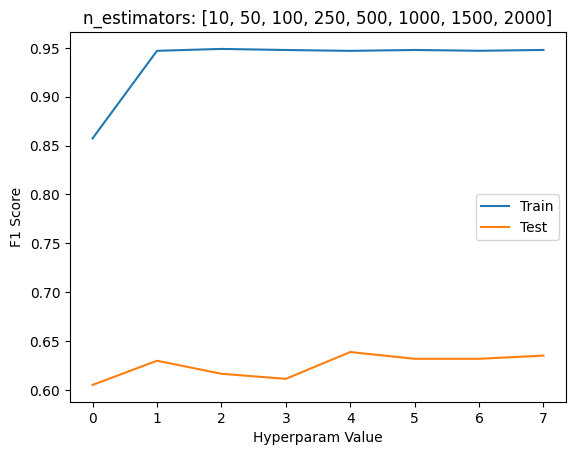

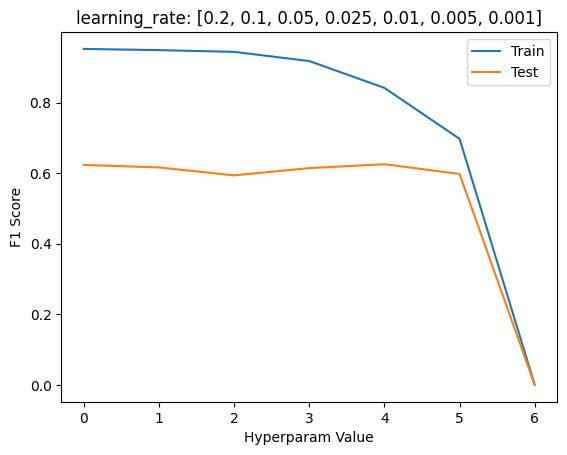

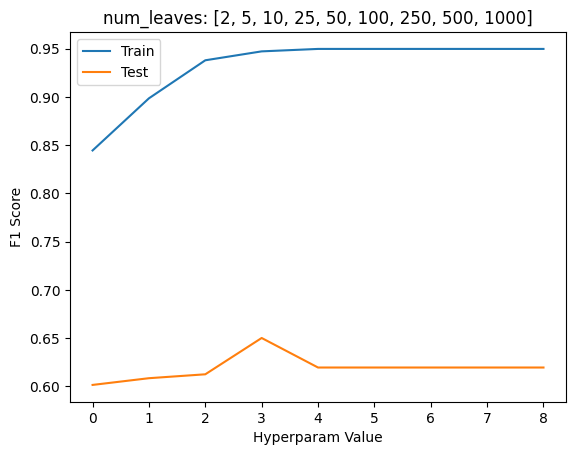

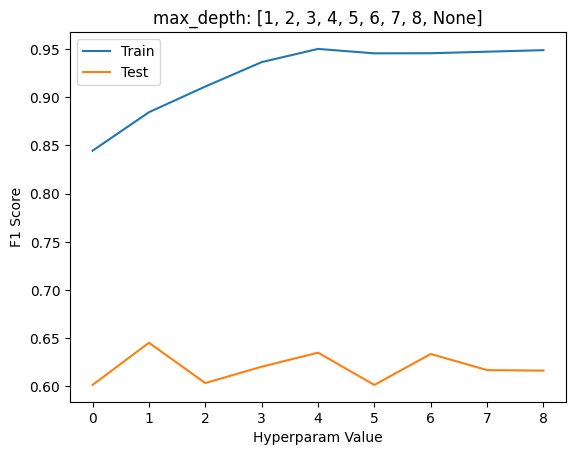

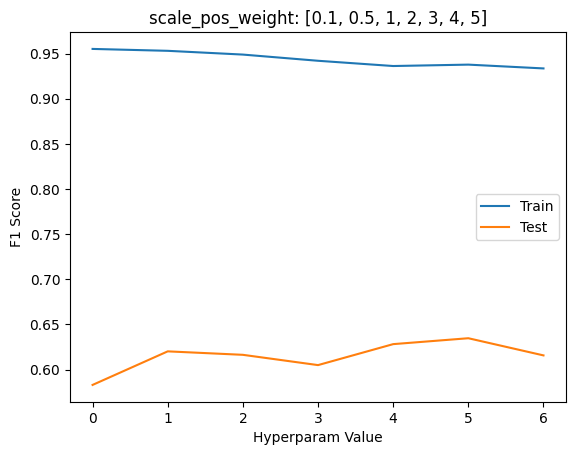

In [291]:

for k in train_scores.keys():
    plt.figure()
    plt.plot(list(range(len(train_scores[k]))), train_scores[k])
    plt.plot(list(range(len(train_scores[k]))), test_scores[k])
    plt.title(k + ": " + str(param_grid[k]))
    plt.xlabel("Hyperparam Value")
    plt.ylabel("F1 Score")
    plt.legend(["Train", "Test"])
    plt.show()

In [292]:
# Get best hyperparameters
best_params = {}
for k,v in train_scores.items():
    best_params[k] = param_grid[k][v.index(max(v))]
print(best_params)    

{'n_estimators': 100, 'learning_rate': 0.2, 'num_leaves': 50, 'max_depth': 5, 'scale_pos_weight': 0.1}


In [293]:
# Train model with best hyperparameters
gbm_tuned = lgb.LGBMClassifier(**best_params)
gbm_tuned.fit(train_X, train_Y,
              eval_metric=lgb_f1_score)

train_f1 = get_f1(gbm_tuned, train_X, train_Y)
print("Train f1: ", train_f1)

test_f1 = get_f1(gbm_tuned, test_X, test_Y)
print("Test f1: ", test_f1)

Train f1:  1.0
Test f1:  0.6071428571428571


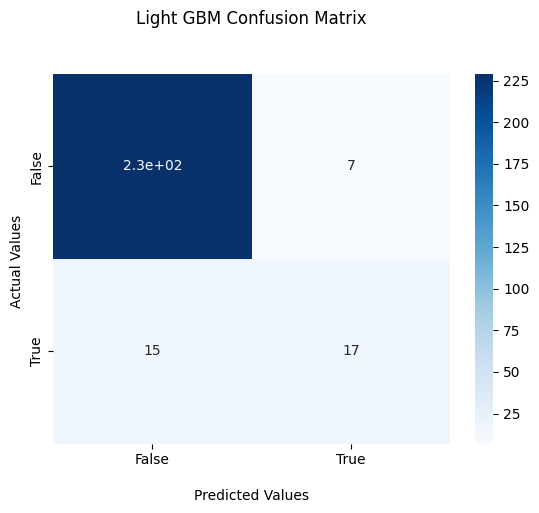

In [300]:
# Make a confusion matrix
c_matrix = confusion_matrix(test_Y, gbm_tuned.predict(test_X))
ax = sns.heatmap(c_matrix, annot=True, cmap='Blues')
ax.set_title('Light GBM Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [294]:
sub_preds = gbm_tuned.predict(submission_data)

print( sum(sub_preds) / len(sub_preds))
print( sum(train_Y) / len(train_Y))
print( sum(test_Y) / len(test_Y))

0.07142857142857142
0.36363636363636365
0.11940298507462686


In [295]:
# get predictions for submission
sub_preds = gbm_tuned.predict(submission_data)
ids = list(range(0, len(sub_preds)))

output_data = pd.DataFrame({"Id": ids, "Predicted": sub_preds})
output_data = output_data.set_index("Id")

output_data.to_csv("gbm_submission.csv")